In [349]:
#import các thư viện
import pandas as pd
import numpy as np
%matplotlib inline 
#to plot the whatever graphic
import matplotlib.pyplot as plt #plot data
import warnings
warnings.filterwarnings('ignore')
from pandas import Series
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.stattools import adfuller
import investpy
import datetime as dt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.tools import diff
from pmdarima import auto_arima

In [282]:
#import data
df_MBB = pd.read_csv('MBB Historical Data.csv')


In [283]:
df_MBB


,Date,Price,Open,High,Low,Vol.,Change %
0,4/19/2023,18100.0,18250.0,18300.0,18100.0,4160000,-0.28%
1,4/18/2023,18150.0,18350.0,18400.0,18050.0,5960000,-0.55%
2,4/17/2023,18250.0,18200.0,18350.0,18150.0,5540000,-0.27%
3,4/14/2023,18300.0,18600.0,18700.0,18300.0,7850000,-1.35%
4,4/13/2023,18550.0,18700.0,18750.0,18500.0,5960000,-0.80%
...,...,...,...,...,...,...,...
1068,1/8/2019,9037.0,9108.9,9156.8,8989.0,6440000,-0.53%
1069,1/7/2019,9084.9,9108.9,9228.7,9060.9,8410000,1.88%
1070,1/4/2019,8917.1,8821.2,9060.9,8653.4,12300000,0.54%
1071,1/3/2019,8869.2,9300.6,9300.6,8869.2,17380000,-4.39%


In [284]:
# Convert the 'date' column to a datetime data type
df_MBB['Date']=pd.to_datetime(df_MBB.Date,format='%m/%d/%Y')


2023-04-19    18100.0
2023-04-18    18150.0
2023-04-17    18250.0
2023-04-14    18300.0
2023-04-13    18550.0
               ...   
2019-01-08     9037.0
2019-01-07     9084.9
2019-01-04     8917.1
2019-01-03     8869.2
2019-01-02     9276.7
Name: Price, Length: 1073, dtype: float64

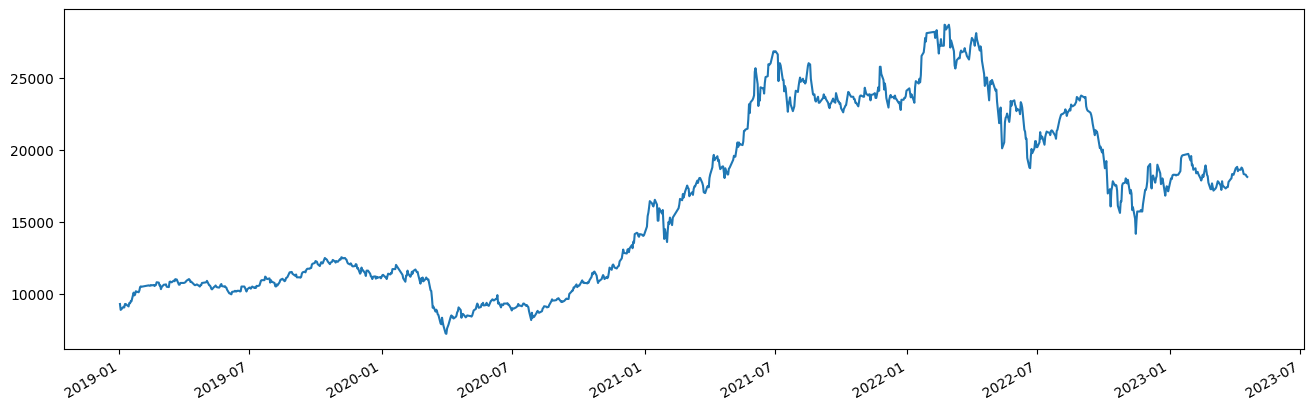

In [285]:
#set cột Date làm cột index
df_MBB=df_MBB.set_index(pd.DatetimeIndex(df_MBB['Date'].values))
df_MBB['Time'] = np.arange(len(df_MBB.index))
df_MBB['Price'].plot(figsize=(16,5))
df_MBB['Price']

In [287]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [288]:
adf_test(df_MBB['Price'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -0.698203
p-value                    0.847214
# lags used                0.000000
# observations          1072.000000
critical value (1%)       -3.436465
critical value (5%)       -2.864240
critical value (10%)      -2.568208
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


p-value > 0.05 nên tệp dữ liệu không có tính dừng

In [289]:
#Kiểm định sai phân bậc 1 của giá Close
df_MBB['d1'] = diff(df_MBB['Price'],k_diff=1)

In [290]:
adf_test(df_MBB['d1'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -24.342594
p-value                    0.000000
# lags used                1.000000
# observations          1070.000000
critical value (1%)       -3.436476
critical value (5%)       -2.864245
critical value (10%)      -2.568210
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


p-value < 0.05 nên tệp dữ liệu có tính dừng

In [291]:
df_MBB

,Date,Price,Open,High,Low,Vol.,Change %,Time,d1
2023-04-19,2023-04-19,18100.0,18250.0,18300.0,18100.0,4160000,-0.28%,0,NaN
2023-04-18,2023-04-18,18150.0,18350.0,18400.0,18050.0,5960000,-0.55%,1,50.0
2023-04-17,2023-04-17,18250.0,18200.0,18350.0,18150.0,5540000,-0.27%,2,100.0
2023-04-14,2023-04-14,18300.0,18600.0,18700.0,18300.0,7850000,-1.35%,3,50.0
2023-04-13,2023-04-13,18550.0,18700.0,18750.0,18500.0,5960000,-0.80%,4,250.0
...,...,...,...,...,...,...,...,...,...
2019-01-08,2019-01-08,9037.0,9108.9,9156.8,8989.0,6440000,-0.53%,1068,-239.7
2019-01-07,2019-01-07,9084.9,9108.9,9228.7,9060.9,8410000,1.88%,1069,47.9
2019-01-04,2019-01-04,8917.1,8821.2,9060.9,8653.4,12300000,0.54%,1070,-167.8
2019-01-03,2019-01-03,8869.2,9300.6,9300.6,8869.2,17380000,-4.39%,1071,-47.9


In [310]:
# Splitting the dataset into 70% training data and 30% testing data.
train_MBB, test_MBB = train_test_split(df_MBB['Price'], test_size=.30,train_size=.70,shuffle=False)

In [311]:
train_MBB

2023-04-19    18100.0
2023-04-18    18150.0
2023-04-17    18250.0
2023-04-14    18300.0
2023-04-13    18550.0
               ...   
2020-04-27     8350.1
2020-04-24     8536.3
2020-04-23     8589.5
2020-04-22     8562.9
2020-04-21     8323.5
Name: Price, Length: 751, dtype: float64

In [281]:
df_MBB = pd.concat([train_MBB, test_MBB],    # Combine vertically
                          ignore_index = True,
                          sort = False)
df_MBB.head(5)   

0    18100.0
1    18150.0
2    18250.0
3    18300.0
4    18550.0
Name: Price, dtype: float64

In [250]:
auto_arima(train_MBB,seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  751
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5616.545
Date:                Mon, 24 Apr 2023   AIC                          11235.091
Time:                        14:24:46   BIC                          11239.711
Sample:                             0   HQIC                         11236.871
                                - 751                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.869e+05   6143.558     30.420      0.000    1.75e+05    1.99e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               305.72
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [293]:
model  = auto_arima(df_MBB['Price'],
                      test='adf',       # use adftest to find optimal 'd' # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)     # set to stepwise
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15749.359, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15751.247, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15751.238, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15747.878, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15751.894, Time=0.20 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.162 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1073
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7872.939
Date:                Mon, 24 Apr 2023   AIC                          15747.878
Time:                        14:29:33   BIC                          15752.855
Sample:                             0   HQIC                         15749.764
          

In [294]:
df_USD = pd.read_csv('USD_VND Historical Data.csv')

In [295]:
df_USD['Date']=pd.to_datetime(df_USD.Date,format='%m/%d/%Y')

2023-04-19    23511.0
2023-04-18    23505.0
2023-04-17    23485.0
2023-04-14    23440.0
2023-04-13    23440.0
               ...   
2019-01-08    23198.5
2019-01-07    23199.0
2019-01-04    23199.0
2019-01-03    23202.5
2019-01-02    23207.5
Name: Price, Length: 1090, dtype: float64

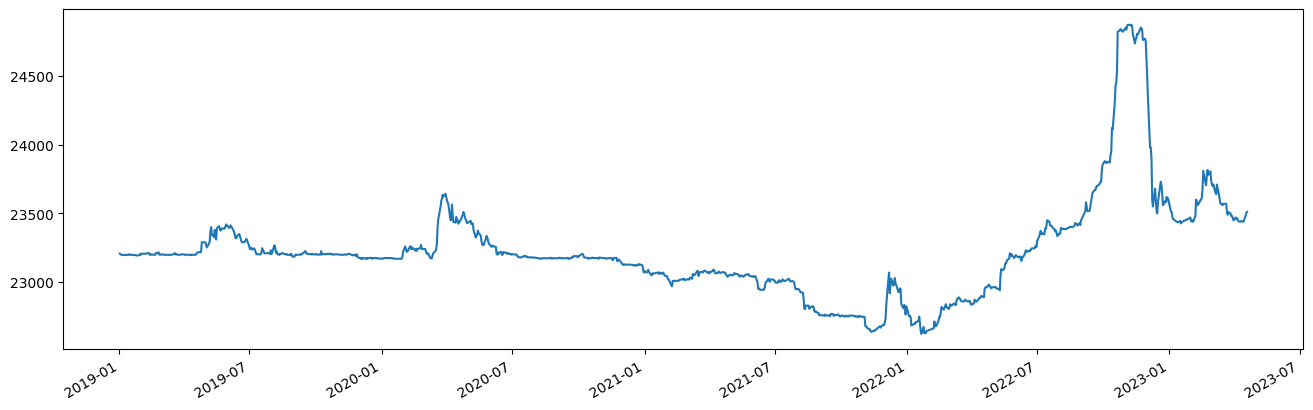

In [296]:
#set cột Date làm cột index
df_USD=df_USD.set_index(pd.DatetimeIndex(df_USD['Date'].values))
df_USD['Time'] = np.arange(len(df_USD.index))
df_USD['Price'].plot(figsize=(16,5))
df_USD['Price']

In [298]:
merged_df = pd.merge(df_MBB, df_USD, on='Date')

In [299]:
merged_df

,Date,Price_x,Open_x,High_x,Low_x,Vol._x,Change %_x,Time_x,d1,Price_y,Open_y,High_y,Low_y,Vol._y,Change %_y,Time_y
0,2023-04-19,18100.0,18250.0,18300.0,18100.0,4160000,-0.28%,0,NaN,23511.0,23517.5,23518.0,23452.0,40,0.03%,0
1,2023-04-18,18150.0,18350.0,18400.0,18050.0,5960000,-0.55%,1,50.0,23505.0,23510.0,23517.0,23472.5,20,0.09%,1
2,2023-04-17,18250.0,18200.0,18350.0,18150.0,5540000,-0.27%,2,100.0,23485.0,23455.0,23495.0,23446.5,30,0.19%,2
3,2023-04-14,18300.0,18600.0,18700.0,18300.0,7850000,-1.35%,3,50.0,23440.0,23445.5,23451.0,23442.5,10,0.00%,3
4,2023-04-13,18550.0,18700.0,18750.0,18500.0,5960000,-0.80%,4,250.0,23440.0,23447.0,23453.5,23440.0,20,-0.01%,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,2019-01-08,9037.0,9108.9,9156.8,8989.0,6440000,-0.53%,1068,-239.7,23198.5,23199.5,23199.5,23190.5,20,0.00%,1085
1069,2019-01-07,9084.9,9108.9,9228.7,9060.9,8410000,1.88%,1069,47.9,23199.0,23197.0,23204.0,23191.0,20,0.00%,1086
1070,2019-01-04,8917.1,8821.2,9060.9,8653.4,12300000,0.54%,1070,-167.8,23199.0,23199.0,23201.0,23193.0,20,-0.02%,1087
1071,2019-01-03,8869.2,9300.6,9300.6,8869.2,17380000,-4.39%,1071,-47.9,23202.5,23204.5,23205.5,23192.5,20,-0.02%,1088


In [312]:
result_USD = merged_df.dropna(subset=['Date'])

In [313]:
result_USD

,Date,Price_x,Open_x,High_x,Low_x,Vol._x,Change %_x,Time_x,d1,Price_y,Open_y,High_y,Low_y,Vol._y,Change %_y,Time_y
0,2023-04-19,18100.0,18250.0,18300.0,18100.0,4160000,-0.28%,0,NaN,23511.0,23517.5,23518.0,23452.0,40,0.03%,0
1,2023-04-18,18150.0,18350.0,18400.0,18050.0,5960000,-0.55%,1,50.0,23505.0,23510.0,23517.0,23472.5,20,0.09%,1
2,2023-04-17,18250.0,18200.0,18350.0,18150.0,5540000,-0.27%,2,100.0,23485.0,23455.0,23495.0,23446.5,30,0.19%,2
3,2023-04-14,18300.0,18600.0,18700.0,18300.0,7850000,-1.35%,3,50.0,23440.0,23445.5,23451.0,23442.5,10,0.00%,3
4,2023-04-13,18550.0,18700.0,18750.0,18500.0,5960000,-0.80%,4,250.0,23440.0,23447.0,23453.5,23440.0,20,-0.01%,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068,2019-01-08,9037.0,9108.9,9156.8,8989.0,6440000,-0.53%,1068,-239.7,23198.5,23199.5,23199.5,23190.5,20,0.00%,1085
1069,2019-01-07,9084.9,9108.9,9228.7,9060.9,8410000,1.88%,1069,47.9,23199.0,23197.0,23204.0,23191.0,20,0.00%,1086
1070,2019-01-04,8917.1,8821.2,9060.9,8653.4,12300000,0.54%,1070,-167.8,23199.0,23199.0,23201.0,23193.0,20,-0.02%,1087
1071,2019-01-03,8869.2,9300.6,9300.6,8869.2,17380000,-4.39%,1071,-47.9,23202.5,23204.5,23205.5,23192.5,20,-0.02%,1088


In [314]:
df_USD=result_USD.drop(columns=['Price_x','Open_x','High_x','Low_x','Vol._x','Change %_x','Time_x','d1'])

In [318]:
df_USD

,Date,Price_y,Open_y,High_y,Low_y,Vol._y,Change %_y,Time_y
0,2023-04-19,23511.0,23517.5,23518.0,23452.0,40,0.03%,0
1,2023-04-18,23505.0,23510.0,23517.0,23472.5,20,0.09%,1
2,2023-04-17,23485.0,23455.0,23495.0,23446.5,30,0.19%,2
3,2023-04-14,23440.0,23445.5,23451.0,23442.5,10,0.00%,3
4,2023-04-13,23440.0,23447.0,23453.5,23440.0,20,-0.01%,4
...,...,...,...,...,...,...,...,...
1068,2019-01-08,23198.5,23199.5,23199.5,23190.5,20,0.00%,1085
1069,2019-01-07,23199.0,23197.0,23204.0,23191.0,20,0.00%,1086
1070,2019-01-04,23199.0,23199.0,23201.0,23193.0,20,-0.02%,1087
1071,2019-01-03,23202.5,23204.5,23205.5,23192.5,20,-0.02%,1088


In [324]:
# Splitting the dataset into 70% training data and 30% testing data.
train_USD, test_USD = train_test_split(df_USD['Price_y'], test_size=.30, train_size=.70,shuffle=False)

In [325]:
train_USD

2023-04-19    23511.0
2023-04-18    23505.0
2023-04-17    23485.0
2023-04-14    23440.0
2023-04-13    23440.0
               ...   
2020-04-27    23456.5
2020-04-24    23510.0
2020-04-23    23486.0
2020-04-22    23480.0
2020-04-21    23461.0
Name: Price_y, Length: 751, dtype: float64

2023-04-19    23511.0
2023-04-18    23505.0
2023-04-17    23485.0
2023-04-14    23440.0
2023-04-13    23440.0
               ...   
2019-01-08    23198.5
2019-01-07    23199.0
2019-01-04    23199.0
2019-01-03    23202.5
2019-01-02    23207.5
Name: Price_y, Length: 1073, dtype: float64

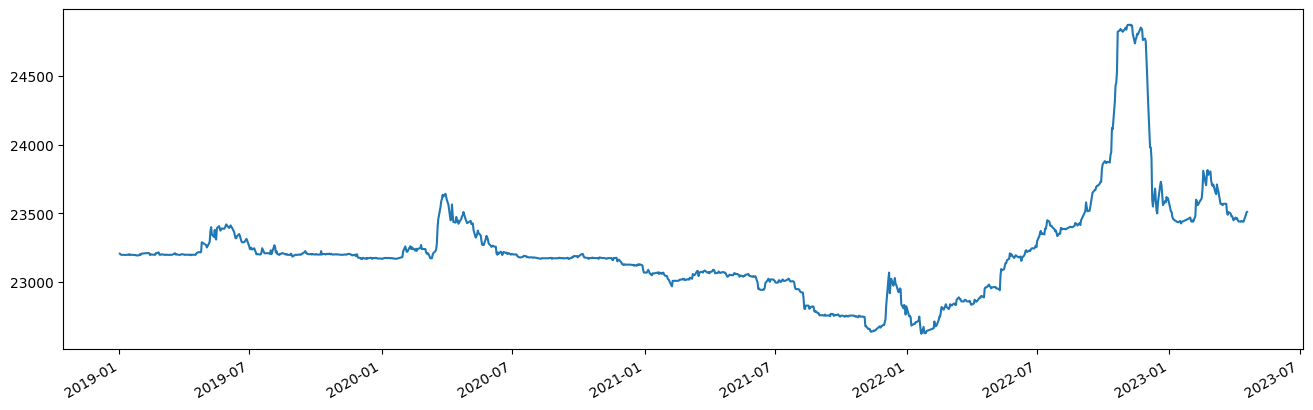

In [319]:
#set cột Date làm cột index
df_USD=df_USD.set_index(pd.DatetimeIndex(df_USD['Date'].values))
df_USD['Time'] = np.arange(len(df_USD.index))
df_USD['Price_y'].plot(figsize=(16,5))
df_USD['Price_y']

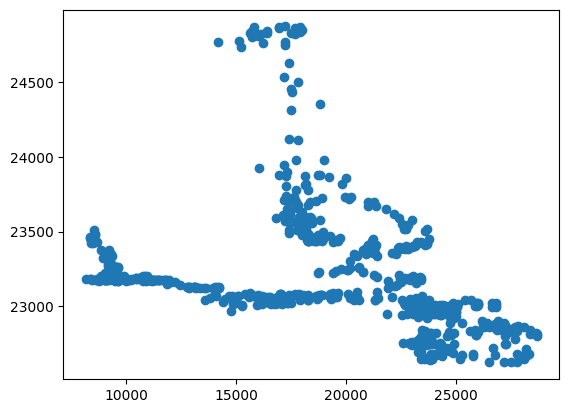

In [326]:
plt.scatter(x=train_MBB,y= train_USD )
plt.show()

In [327]:
corr= train_MBB.corr(train_USD)


In [328]:
corr

-0.32485056002270857

In [329]:
from statsmodels.tsa.arima_model import ARIMA

In [330]:
model = auto_arima(train_MBB, exogenous=train_USD, seasonal=False,trace=True,error_action='ignore', suppress_warnings=True)



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11237.816, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11236.409, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11238.341, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11238.340, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11235.091, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11239.444, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.910 seconds


In [331]:
model = sm.tsa.ARIMA(endog=train_MBB,exog=train_USD,order=(0,1,0)).fit()

<Axes: >

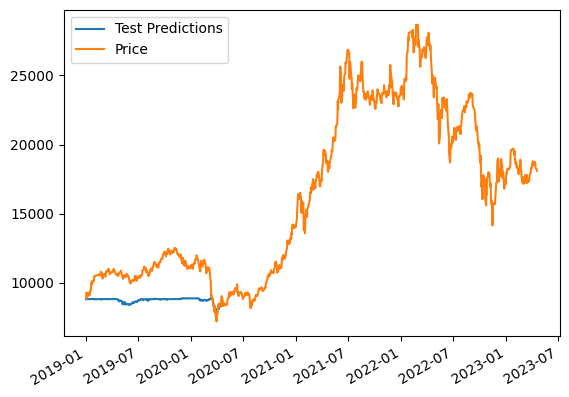

In [332]:
start_test = len(train_MBB)
end_test = len(train_MBB) + len(test_MBB) - 1
# start_val = len(train) + len(test)
# end_val = len(train) + len(test) + len(val) - 1
predictions_test = model.predict(start=start_test, exog=test_USD, end=end_test, typ='levels').rename('Test Predictions')
#predictions_val = model_fit.predict(start=start_val, end=end_val, typ='levels').rename('Validate Predictions')
predictions_test.index = test_MBB.index
#predictions_val.index = val.index
predictions_test.plot(legend=True)
#predictions_val.plot(legend=True)
df_MBB['Price'].plot(legend=True)

In [164]:
import statsmodels.api as sm

In [334]:
train_MBB

2023-04-19    18100.0
2023-04-18    18150.0
2023-04-17    18250.0
2023-04-14    18300.0
2023-04-13    18550.0
               ...   
2020-04-27     8350.1
2020-04-24     8536.3
2020-04-23     8589.5
2020-04-22     8562.9
2020-04-21     8323.5
Name: Price, Length: 751, dtype: float64

In [48]:
from sklearn.model_selection import train_test_split

In [335]:
mse = mean_squared_error(test_MBB['Price'], predictions_test)
rmse = np.sqrt(mse) 
print("Root Mean Square Error:\n")  
print(rmse)  
     

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "pandas\_libs\tslibs\parsing.pyx", line 440, in pandas._libs.tslibs.parsing.parse_datetime_string_with_reso
  File "pandas\_libs\tslibs\parsing.pyx", line 649, in pandas._libs.tslibs.parsing.dateutil_parse
ValueError: Unknown datetime string format, unable to parse: Price

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\datetimes.py", line 704, in get_loc
    parsed, reso = self._parse_with_reso(key)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\indexes\datetimelike.py", line 230, in _parse_with_reso
    parsed, reso_str = parsing.parse_time_string(label, freq)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "pandas\_libs\tslibs\parsing.pyx", line 367, in pandas._libs.tslibs.par

In [345]:
mae= mean_absolute_error(test_MBB, predictions_test)
mape = mean_absolute_percentage_error(test_MBB, predictions_test)
mse = mean_squared_error(test_MBB, predictions_test)

print(f"MAE: {mae:.2f}")

MAE: 2050.35


In [343]:
mape = mean_absolute_percentage_error(test_MBB, predictions_test)
print(f"MAPE: {mape * 100:.2f}%")

MAPE: 18.40%


In [346]:
mse = mean_squared_error(test_MBB, predictions_test)
print(f"MSE: {mse:.2f}")

MSE: 4973050.06


In [347]:
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f}")

RMSE: 2230.03


In [350]:
r2 = r2_score(test_MBB, predictions_test)
print(f"R2: {r2:.2f}")

R2: -3.64


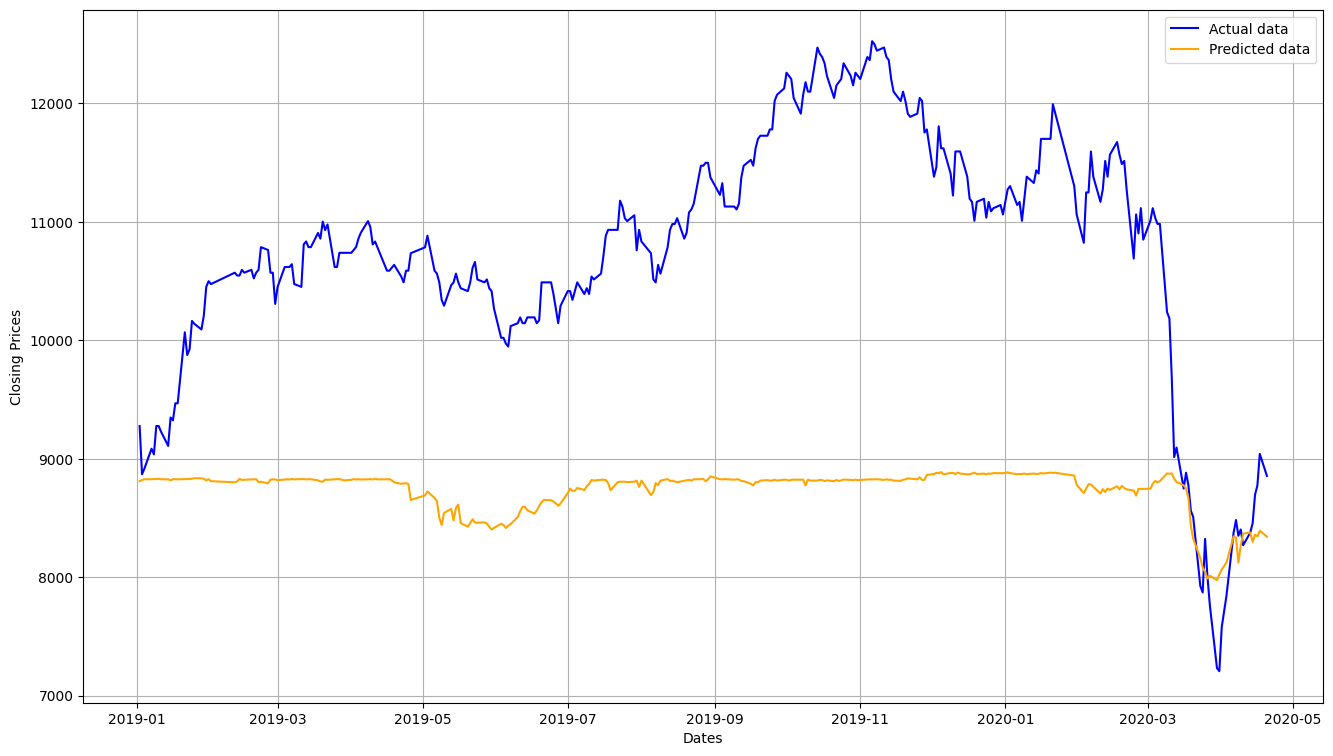

In [353]:
pred_series = pd.Series(predictions_test, index=predictions_test.index)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_MBB, 'blue', label='Actual data')
plt.plot(pred_series, 'orange', label='Predicted data')
plt.legend()

In [358]:
scale = StandardScaler()

In [361]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import column_or_1d
actual = column_or_1d(test_MBB)
pred = column_or_1d(predictions_test)

inv_actual = scale.transform(actual.reshape(-1, 1))
inv_pred = scale.transform(pred.reshape(-1, 1))

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.